In [2]:
from MVN import MultivariateNormal
from MCMC import MetropolisHastings, Gibbs, Cholesky, SampleSet2D
from multiple_chains import MultipleChains, errors_sampler, plot_errors
from tqdm import tqdm

In [3]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

CL = .90

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

# n.plot_2d_analytical(3, 1, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [4]:
# Let us see some numbers

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)
print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

The Credible Interval for x is between 2.03 and 5.97
The Credible Interval for y is between 0.52 and 3.48


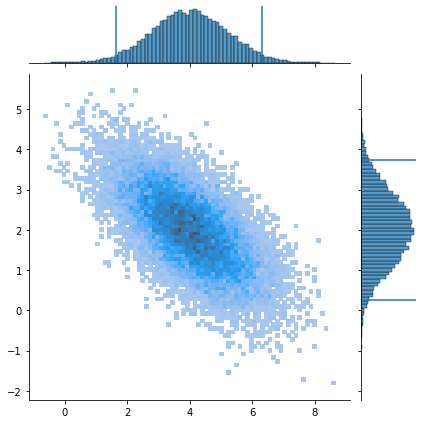

In [5]:
# CHOLESKY SAMPLING

samples_ch = SampleSet2D(n.cholesky_sample(20000))
samples_ch.samples_plot(.95, kind='hist')

In [6]:
# METROPOLIS - HASTINGS SAMPLING

# def gaussian_proposal(theta=None):
#     return (np.random.normal(scale=1, size=2))
from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

num_chains = 7
spread_initial_positions = 10
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

chain_length = 200

mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

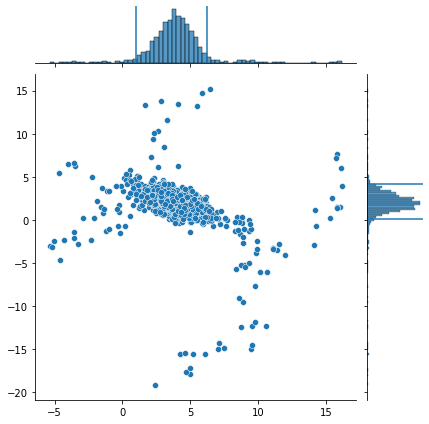

In [7]:
samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL, kind='scatter')

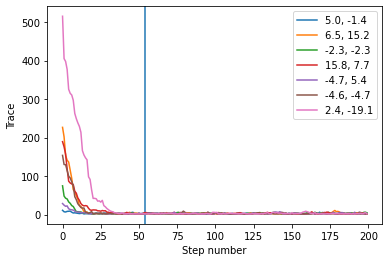

In [8]:
plt.axvline(mh.optimal_trimming)
mh.traces_plot(every=1)

In [9]:
mh.trim_chains(mh.optimal_trimming)
mh.extend_chains(int(1e4))

Trimming at 54


In [10]:
print(mh.R_estimator()) # < 1.02 in all its entries!
print(mh.autocorrelation_times()) # all close to 1! great
# am I underestimating these?

[[1.00031944 1.00066809]
 [1.00066809 1.0005966 ]]
[1.000177514144461, 1.0011994153621495, 1.0010926496305792, 1.0005185228614768, 1.0004403124805308, 0.9996834684142528, 1.0003127715737496]


In [11]:
# SampleSet2D(mh.all_chains).samples_plot(CL, kind='kde')

In [12]:
# GIBBS SAMPLING
# from our distribution n

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)


Trimming at 4


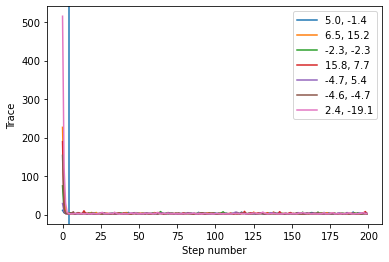

In [13]:
plt.axvline(g.optimal_trimming)
g.traces_plot(every=1)
g.trim_chains(g.optimal_trimming)

In [14]:
g.extend_chains(int(1e3))

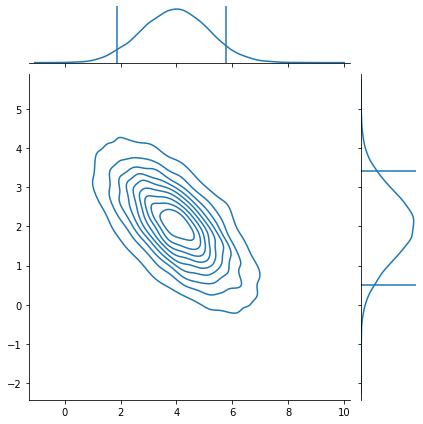

In [15]:
SampleSet2D(g.all_chains).samples_plot(CL, kind='kde')

In [25]:
chain_length = 10
# mc_1 = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)
mc_1 = MultipleChains(MetropolisHastings, n.pdf, initial_positions[:1], chain_length, gaussian_proposal)
# mc_1 = MultipleChains(Cholesky, n.pdf, initial_positions, chain_length, n.cholesky_sample)

trimming_index = 40
N, e_mean, e_cov = errors_sampler(mc_1, n, max_num=int(2e5), trimming_index=trimming_index)

39it [00:02, 18.23it/s]All thresholds too low!
No trimming
200it [00:53,  3.75it/s]


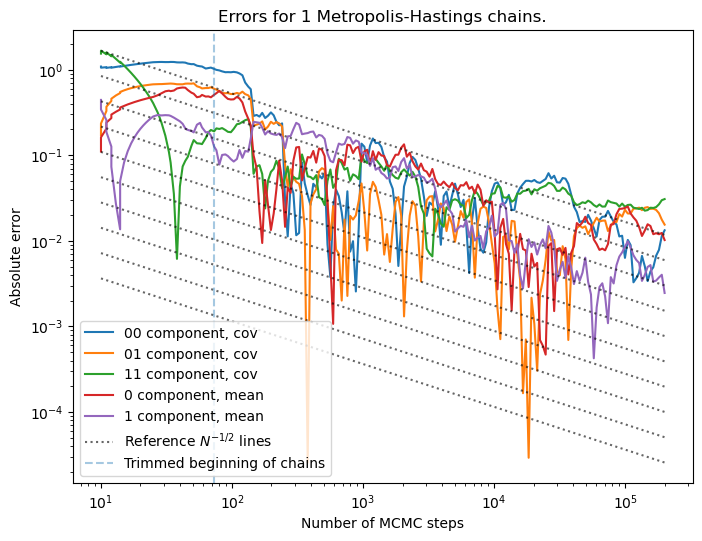

In [26]:
plot_errors(N, e_mean, e_cov, mc_1, trimming_index=trimming_index)
plt.savefig('errors_mh_1.pdf')

array([[ 4.96714153, -1.38264301],
       [ 6.47688538, 15.23029856],
       [-2.34153375, -2.34136957]])